In [25]:
import os, pickle, sys
import torch
import numpy as np
import loadVim as lv
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
def getDirections(model, image, label):
    image.requires_grad = True
    model.zero_grad()
    model.eval()
    output = model(image)
    loss = torch.nn.CrossEntropyLoss()(output.logits, label)
    loss.backward()

    gradient = image.grad
    random = torch.randn_like(gradient)

    # Normalize the directions
    gradient = gradient / torch.norm(gradient)
    random = random / torch.norm(random)
    return gradient, random

In [27]:
def calcGrids(model, image, label, scale=1, num_points=11, directions=None):
    if directions is not None:
        gradient, random = directions
    else:
        gradient, random = getDirections(model, image, label)

    # scale the directions
    gradient *= scale
    random *= scale

    # Calculate loss for all points in neighborhood of image
    X, Y = list(np.linspace(-1, 1, num_points)), list(np.linspace(-1, 1, num_points))
    # for each element in X, multiply by gradient
    XX = [gradient * eps for eps in X]
    YY = [random * eps for eps in Y]

    lossgrid = np.zeros((len(XX), len(YY)))
    classgrid = np.zeros((len(XX), len(YY)))
    for i in range(len(XX)):
        for j in range(len(YY)):
            perturbed_image = image + XX[i] + YY[j]
            # get loss of each perturbed image
            output = model(perturbed_image)
            loss = torch.nn.CrossEntropyLoss()(output.logits, label)
            lossgrid[i][j] = loss
            classgrid[i][j] = torch.argmax(output.logits).item()
    
    X, Y = np.meshgrid(X, Y)
    
    return X, Y, lossgrid, classgrid

In [28]:
def plotLossLandscape(X, Y , lossgrid, title):
    fig = plt.figure()
    fig.set_size_inches(7, 7)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, lossgrid, cmap=cm.coolwarm)
    ax.set_xlabel('ε perturbation along v1')     
    ax.set_ylabel('ε perturbation along v2')
    ax.set_zlabel('Loss')
    ax.set_title(title)
    ax.set_box_aspect(aspect=None, zoom=0.85)
    plt.show()
    

In [29]:
def plotDecisionBoundary(classgrid):
    # Plot the class grid with each distinct class having a distinct color
    fig = plt.figure()
    fig.set_size_inches(7, 7)
    ax = fig.add_subplot(111)
    ax.imshow(classgrid, cmap='plasma', origin="lower")
    # set x and y ticks to be the same from -1 to 1
    ax.set_xticks(np.linspace(0, classgrid.shape[0]-1, 3))
    ax.set_xticklabels(np.linspace(-1, 1, 3))
    ax.set_yticks(np.linspace(0, classgrid.shape[1]-1, 3))
    ax.set_yticklabels(np.linspace(-1, 1, 3))
    ax.set_xlabel('ε perturbation along v1')     
    ax.set_ylabel('ε perturbation along v2')
    ax.set_title("Class Landscape of Image")
    plt.show()

In [30]:
def plotBoth(X, Y, lossgrid, classgrid):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(14, 7)
    axs[0].imshow(classgrid, cmap='plasma', origin="lower")
    axs[0].set_xticks(np.linspace(0, classgrid.shape[0]-1, 3))
    axs[0].set_xticklabels(np.linspace(-1, 1, 3))
    axs[0].set_yticks(np.linspace(0, classgrid.shape[1]-1, 3))
    axs[0].set_yticklabels(np.linspace(-1, 1, 3))
    axs[0].set_xlabel('ε perturbation along v1')     
    axs[0].set_ylabel('ε perturbation along v2')
    axs[0].set_title("Class Landscape of Image Neighborhood")
    
    # Hide axes for the second plot
    axs[1].axis('off')
    axs[1] = fig.add_subplot(122, projection='3d')
    axs[1].plot_surface(X, Y, lossgrid, cmap=cm.coolwarm)
    axs[1].set_xlabel('ε perturbation along v1')     
    axs[1].set_ylabel('ε perturbation along v2')
    axs[1].set_zlabel('Loss')
    axs[1].set_title("Loss Landscape of Image Neighborhood")
    axs[1].set_box_aspect(aspect=None, zoom=0.85)
    plt.show()

In [31]:
model, processor = lv.prepareDownstreamVit()
transform = transforms.Compose([
        lambda image: processor(images=image, return_tensors='pt')['pixel_values'].squeeze(0)
    ])

path_data = os.path.join(os.getcwd(), 'CelebSubset/CelebVal')
path_checkpoint = os.path.join(os.getcwd(), 'models/VitA.pth')

dataset = datasets.ImageFolder(path_data, transform = transform)

loader = DataLoader(dataset, batch_size=1, shuffle=False)

checkpoint = torch.load(path_checkpoint)
model.load_state_dict(checkpoint["state_dict"])
model = model.to(device)

image, label = next(iter(loader))
image = image.to(device)
label = label.to(device)

c:\Projects\AdvAttack\.conda\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Demo of loss landscape

In [32]:
gradient, random = getDirections(model, image, label)

In [33]:
# High numpoints makes it a lot slower
X, Y, lossgrid, classgrid = calcGrids(model, image, label, scale=1e3, num_points=20, directions=(gradient, random))


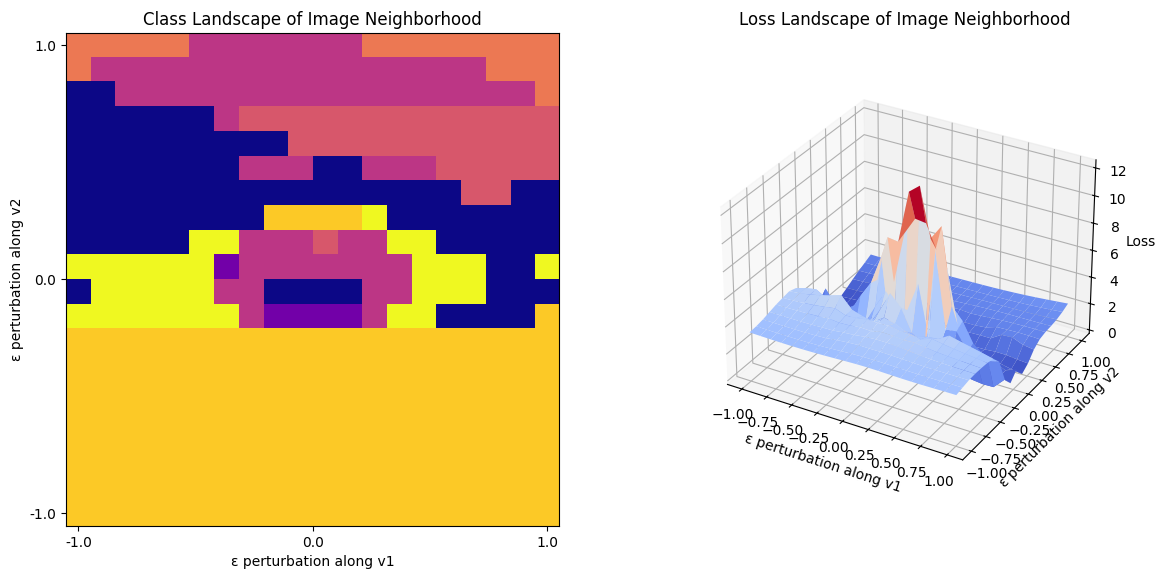

In [34]:
plotBoth(X, Y, lossgrid, classgrid)